<a href="https://colab.research.google.com/github/claredavies/DataEngAPITesting/blob/master/AnamolyDetection/HTTP_Response/Unsupervised/Monitor_Response_Time_Unsupervised_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read in Data

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
df = pd.read_csv('Traffic.csv', parse_dates=['Time'], index_col='Time')

In [3]:
df.head()

,Delay
Time,
2022-05-17 00:00:00,15000
2022-05-17 00:00:10,0
2022-05-17 00:00:20,0
2022-05-17 00:00:30,11000
2022-05-17 00:00:40,19000


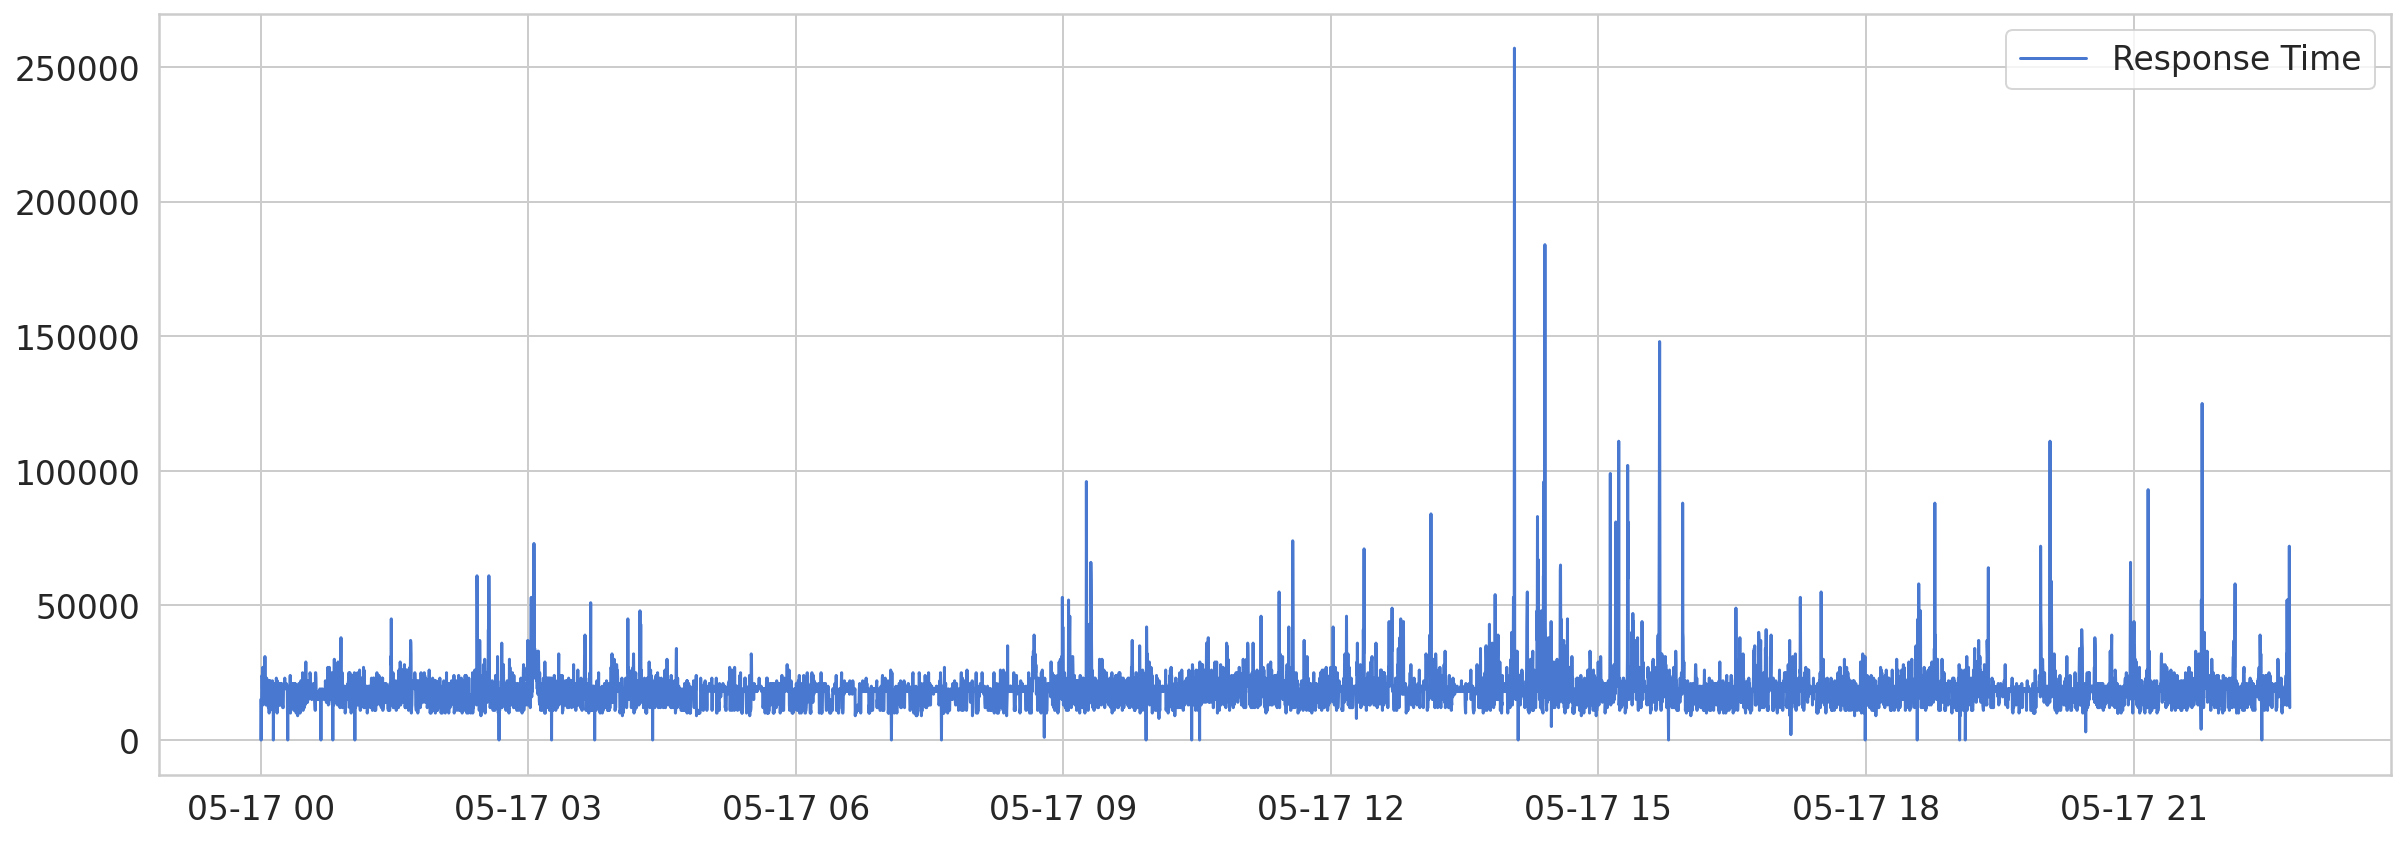

In [32]:
plt.rcParams["figure.figsize"] = (20,7)
plt.plot(df, label='Response Time')
plt.legend();

In [5]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Delay']])

train['Delay'] = scaler.transform(train[['Delay']])
test['Delay'] = scaler.transform(test[['Delay']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# Training

In [12]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [13]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['Delay']], train.Delay, TIME_STEPS)
X_test, y_test = create_dataset(test[['Delay']], test.Delay, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


In [14]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [15]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 4s 9ms/step - loss: 0.5779 - val_loss: 0.5354
Epoch 2/10
218/218 [==============================] - 1s 6ms/step - loss: 0.5774 - val_loss: 0.5353
Epoch 3/10
218/218 [==============================] - 1s 6ms/step - loss: 0.5771 - val_loss: 0.5354
Epoch 4/10
218/218 [==============================] - 1s 6ms/step - loss: 0.5769 - val_loss: 0.5357
Epoch 5/10
218/218 [==============================] - 1s 6ms/step - loss: 0.5767 - val_loss: 0.5360
Epoch 6/10
218/218 [==============================] - 1s 6ms/step - loss: 0.5766 - val_loss: 0.5359
Epoch 7/10
218/218 [==============================] - 1s 6ms/step - loss: 0.5763 - val_loss: 0.5361
Epoch 8/10
218/218 [==============================] - 1s 6ms/step - loss: 0.5763 - val_loss: 0.5361
Epoch 9/10
218/218 [==============================] - 1s 6ms/step - loss: 0.5762 - val_loss: 0.5363
Epoch 10/10
218/218 [==============================] - 1s 6ms/step - loss: 0.5761 - val_loss: 0.5364

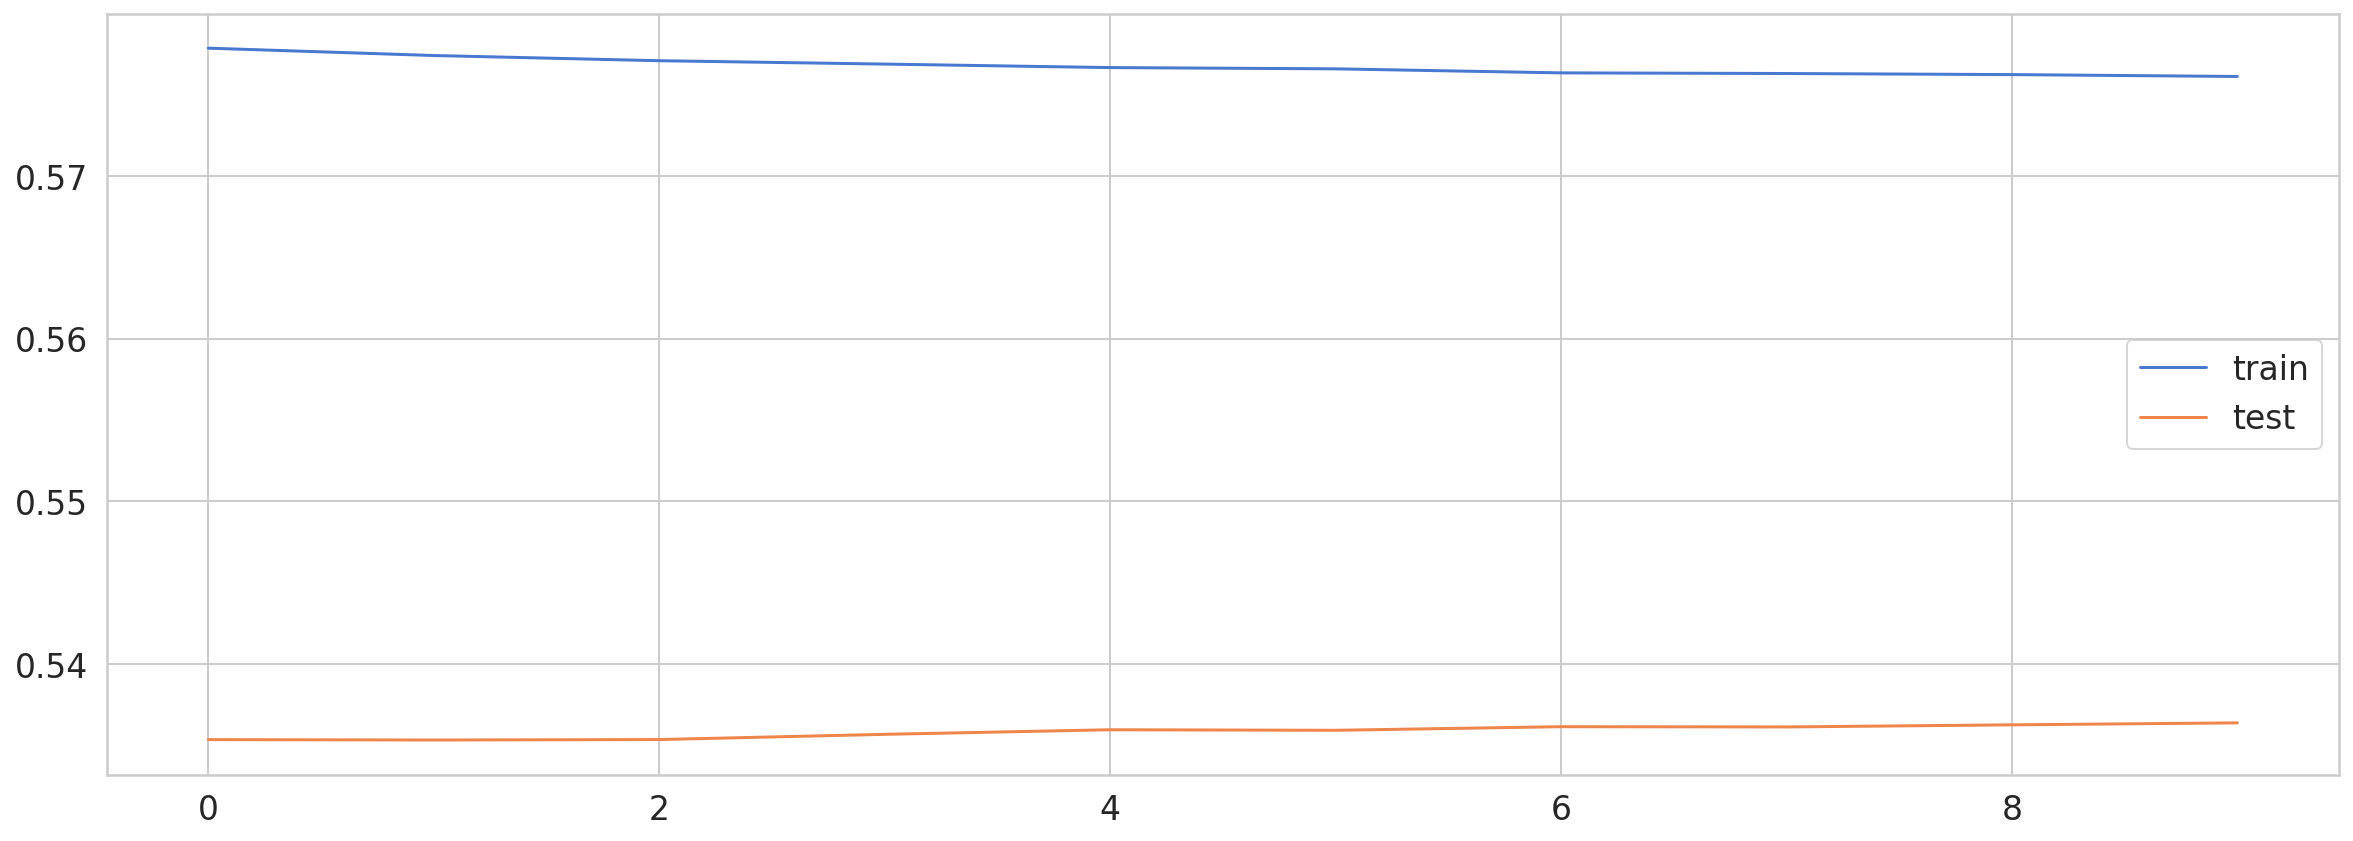

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

# Evaluation

In [17]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


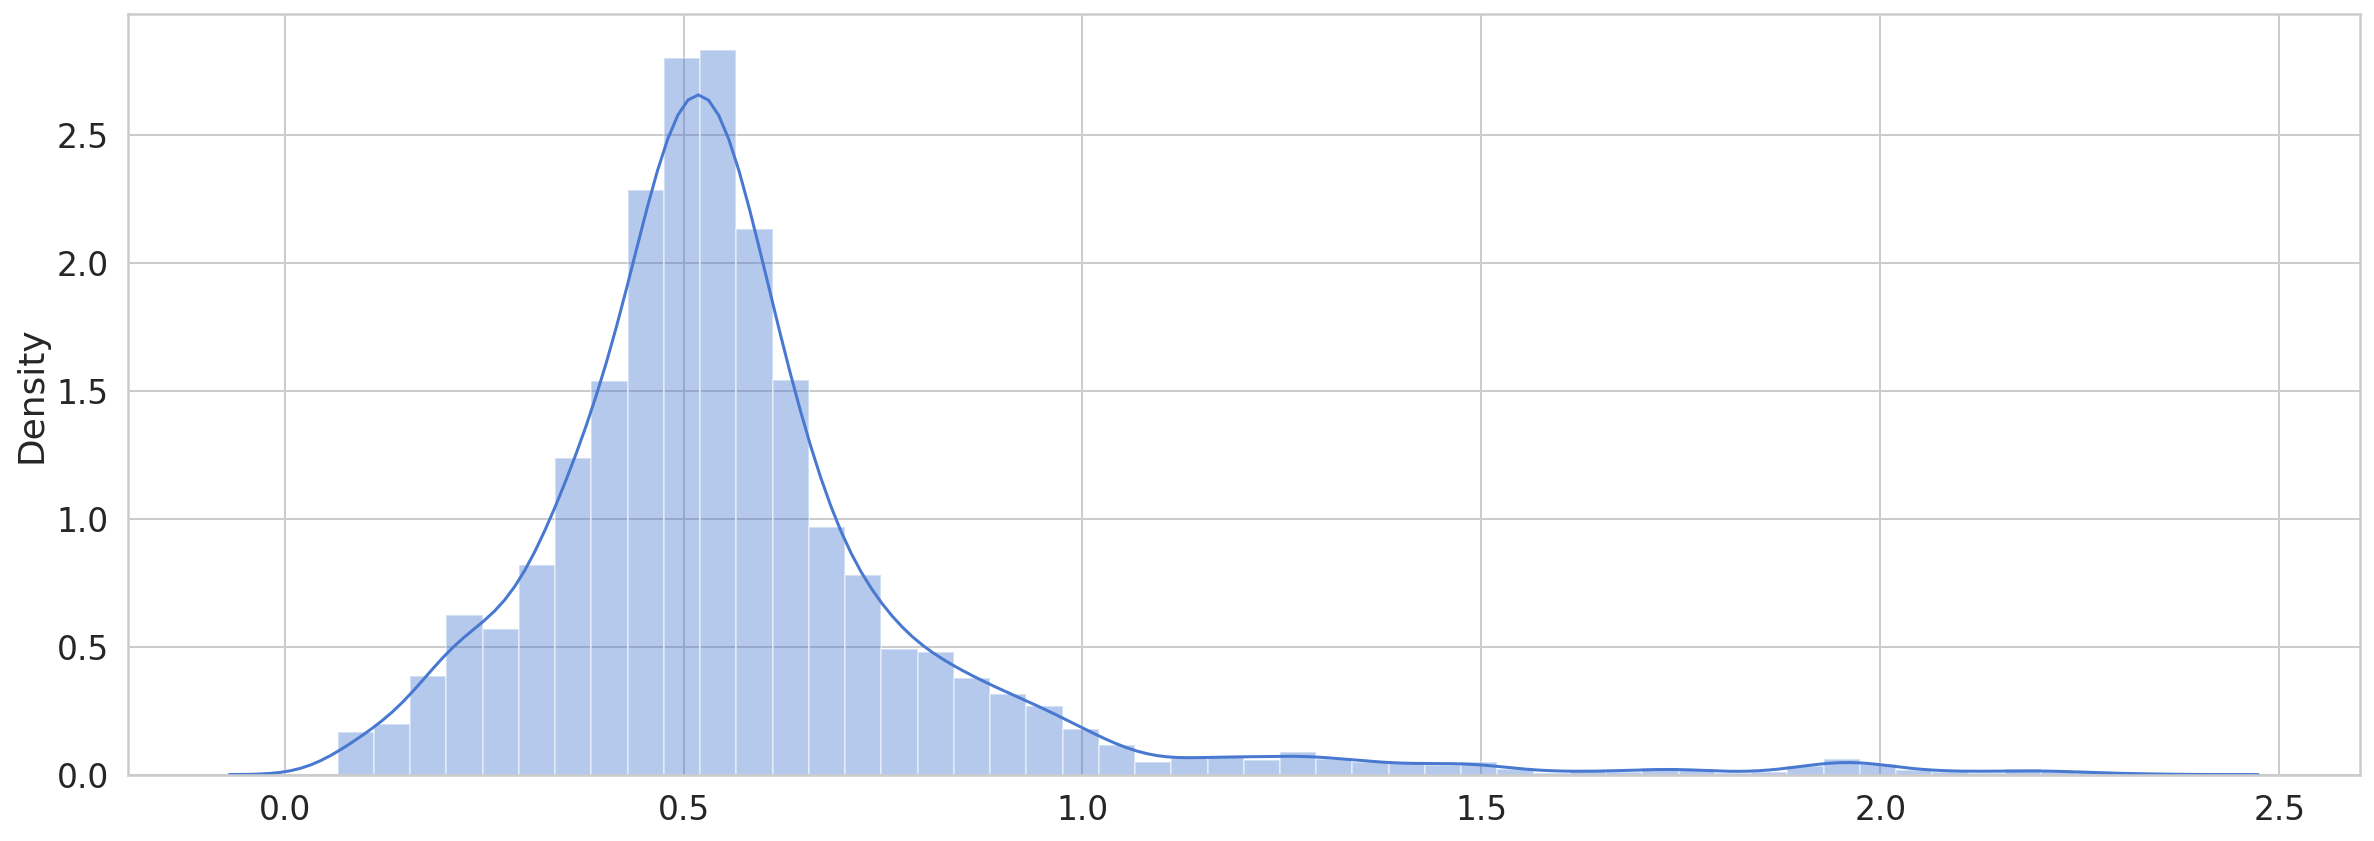

In [33]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [19]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [20]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['delay'] = test[TIME_STEPS:].Delay

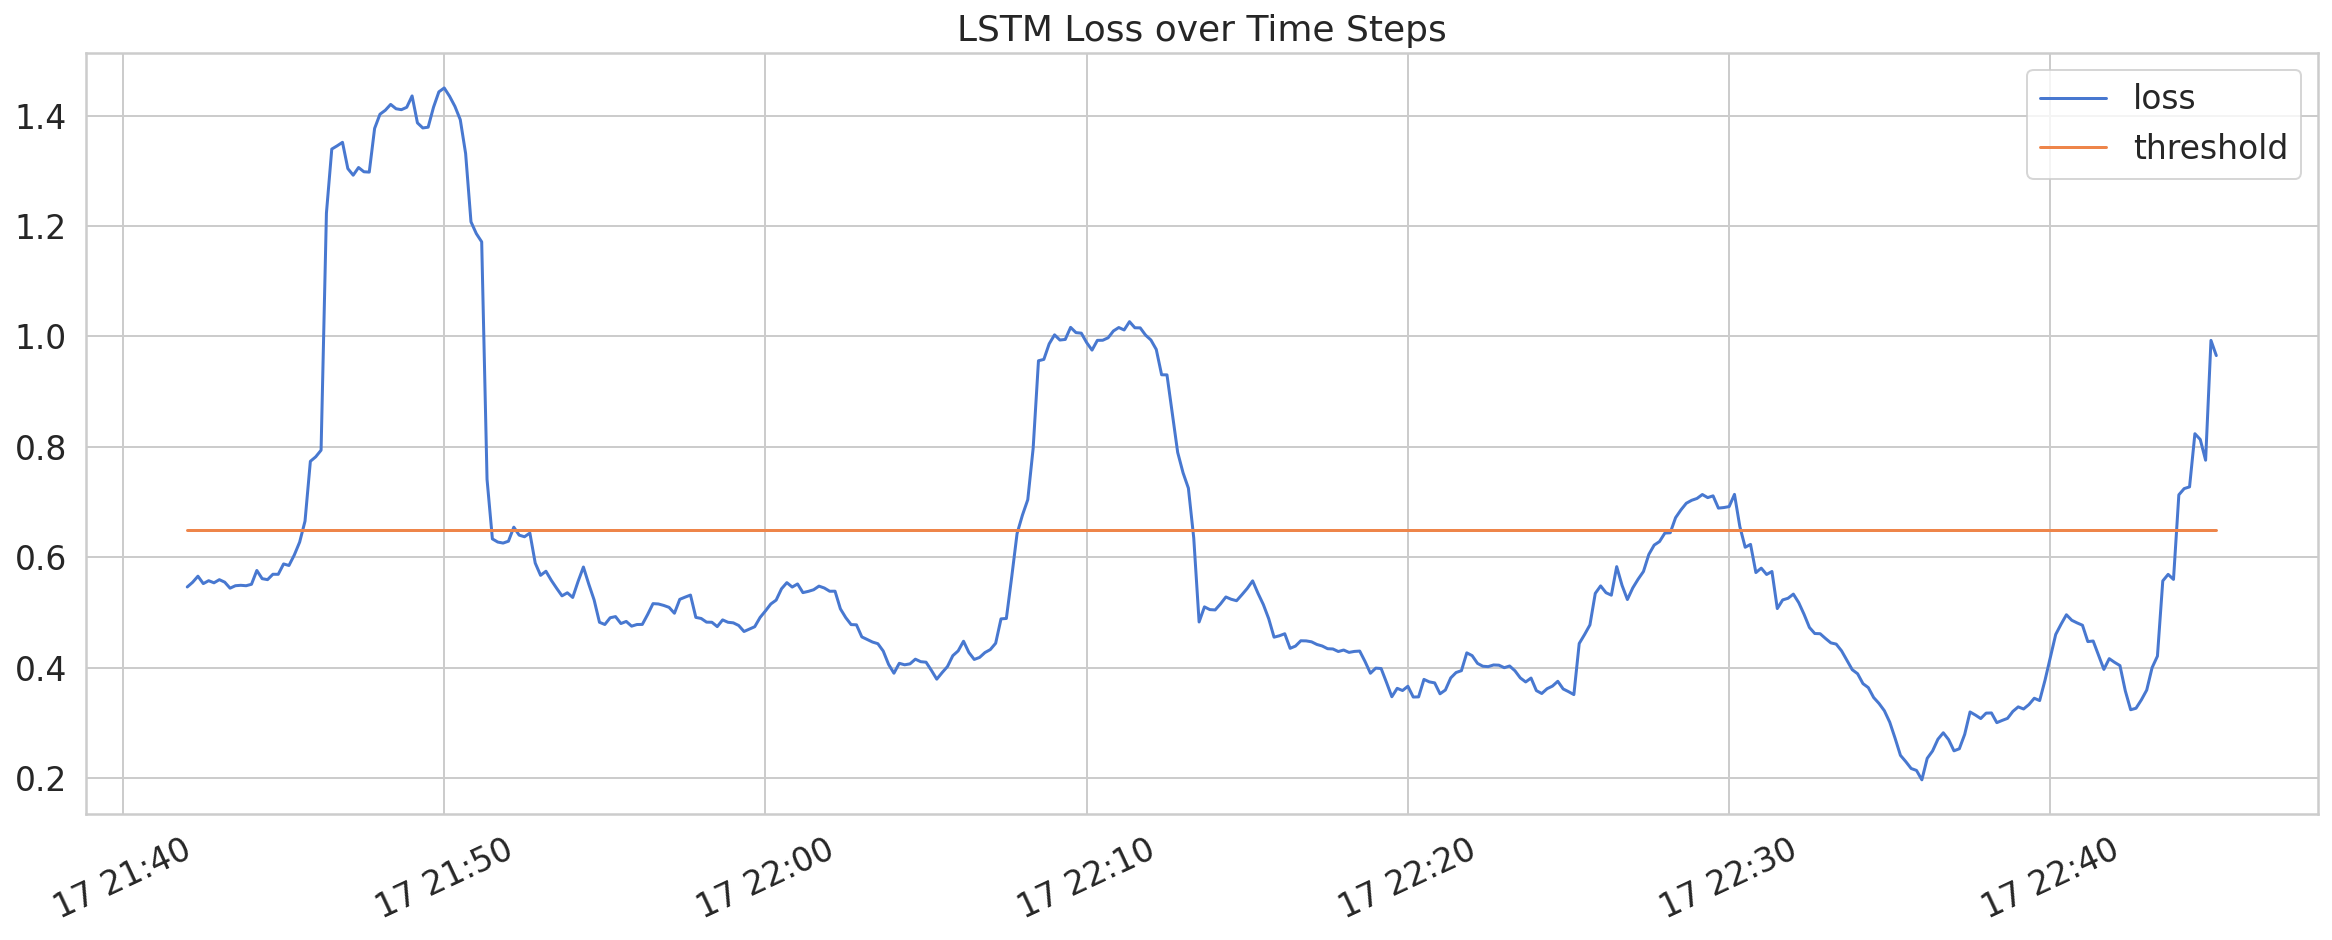

In [34]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.title('LSTM Loss over Time Steps')
plt.xticks(rotation=25)
plt.legend();

In [25]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,delay
Time,,,,
2022-05-17 21:45:40,0.665358,0.65,True,4.160353
2022-05-17 21:45:50,0.773684,0.65,True,-0.702686
2022-05-17 21:46:00,0.781843,0.65,True,-0.827379
2022-05-17 21:46:10,0.793849,0.65,True,13.262964
2022-05-17 21:46:20,1.223250,0.65,True,3.661580


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


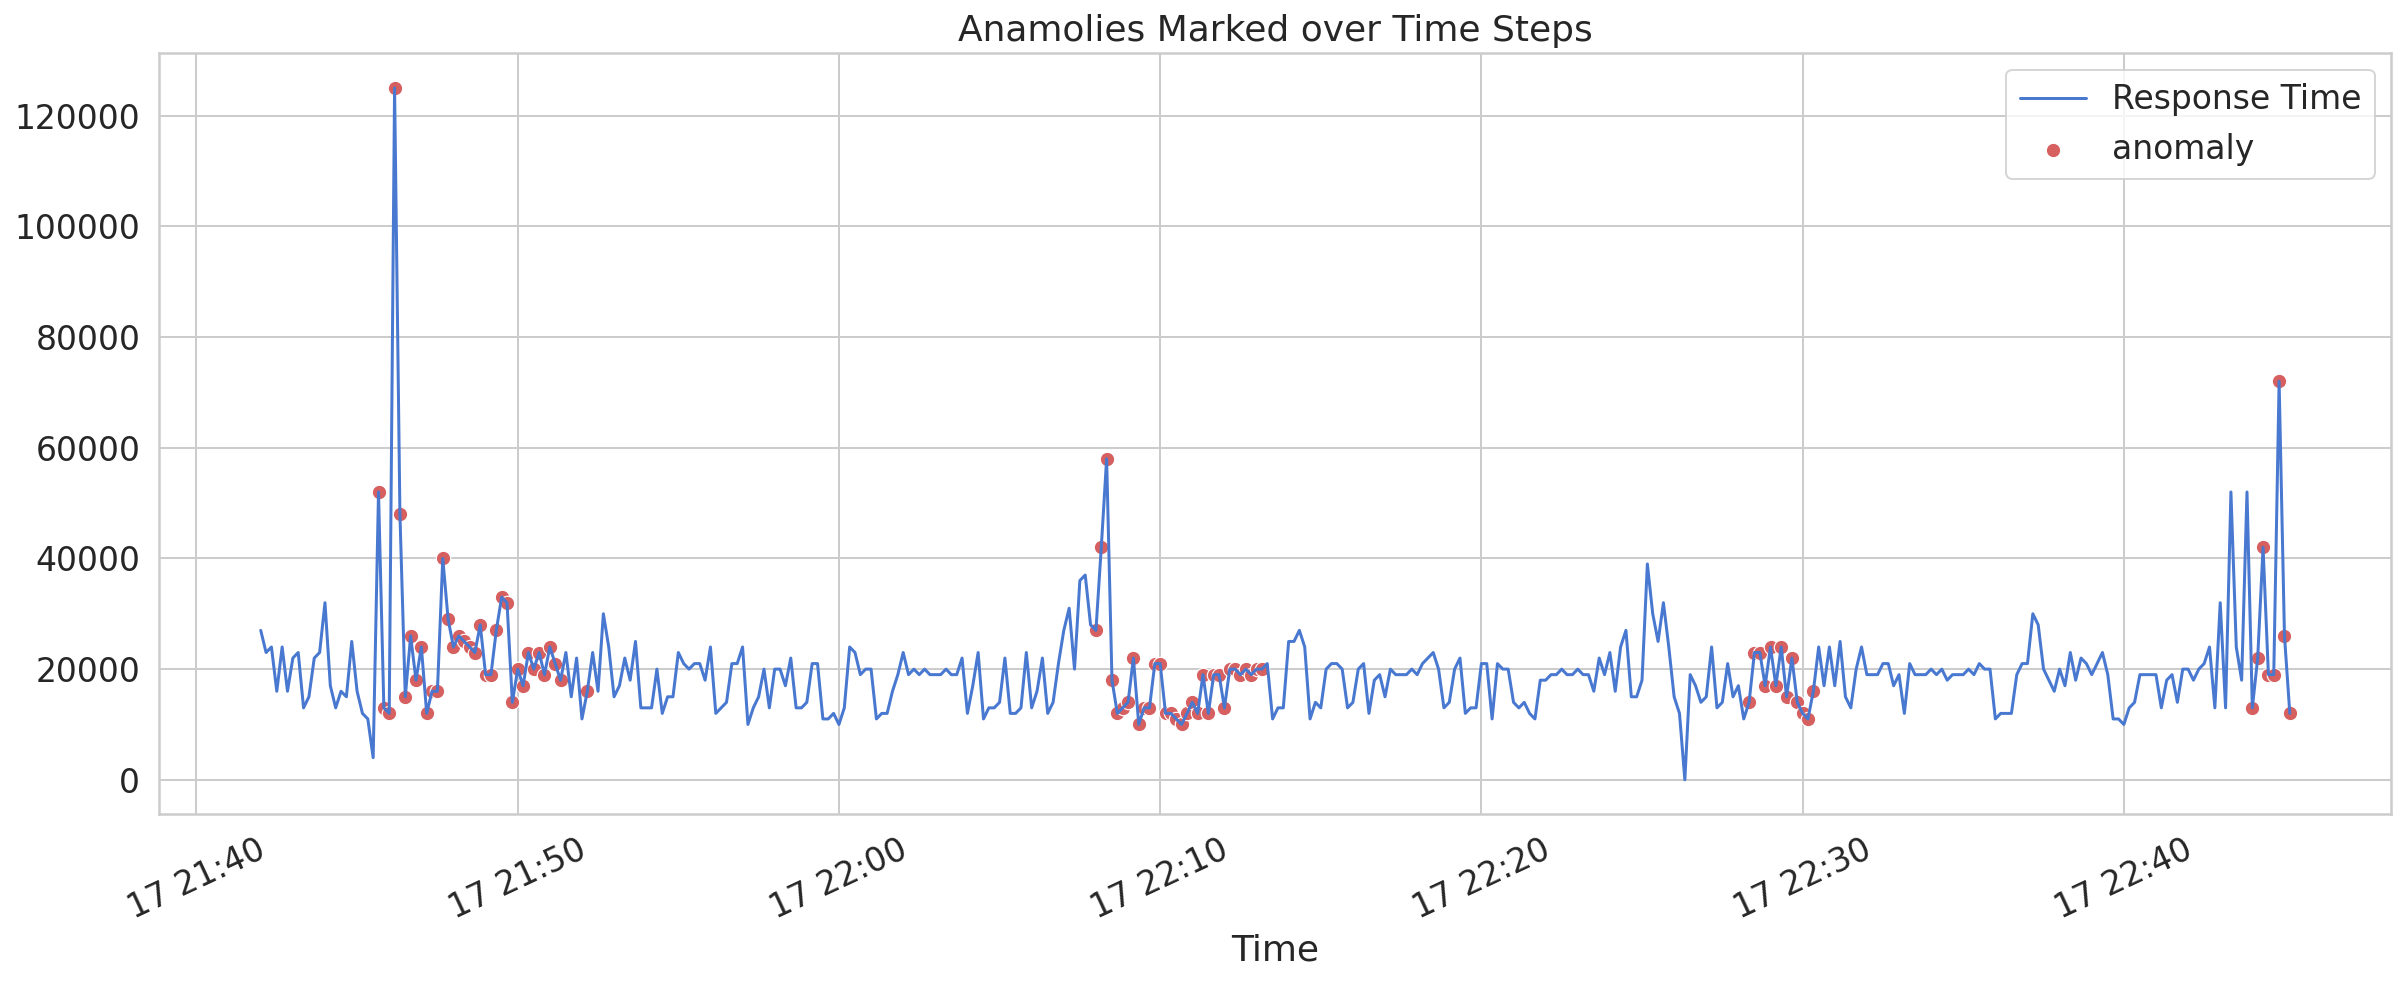

In [35]:


plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform([test[TIME_STEPS:].Delay])[0], 
  label='Response Time'
  );
plt.title('Anamolies Marked over Time Steps')

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform([anomalies.delay])[0],
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();